In [180]:
# Import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import utils.data_preprocessor as dp
from importlib import reload
from sklearn.preprocessing import StandardScaler
import utils.data_wrangling as wr
# add reload to ensure we have latest working version in cache
reload(dp)



<module 'utils.data_preprocessor' from '/Users/emmagore/Desktop/GitHub/INFO-523/final-project-team-5/final-project-team-5-4/utils/data_preprocessor.py'>

In [181]:

# Reading in the csv files
stock_data = dp.read_data('data/stock_data.csv')
unemployment = dp.read_data('data/SeriesReport.csv')

In [182]:
# Print list of missing values per column and preview of df
dp.print_missing(stock_data)
stock_data.head()

dt has 0 missing values
vix has 0 missing values
sp500 has 0 missing values
sp500_volume has 0 missing values
djia has 0 missing values
djia_volume has 0 missing values
hsi has 0 missing values
ads has 0 missing values
us3m has 0 missing values
joblessness has 0 missing values
epu has 0 missing values
GPRD has 0 missing values
prev_day has 0 missing values


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


In [183]:
# Print list of missing values per column and preview of df
dp.print_missing(unemployment)
unemployment.head()

Year has 0 missing values
Jan has 0 missing values
Feb has 0 missing values
Mar has 0 missing values
Apr has 0 missing values
May has 0 missing values
Jun has 0 missing values
Jul has 0 missing values
Aug has 0 missing values
Sep has 0 missing values
Oct has 0 missing values
Nov has 0 missing values
Dec has 0 missing values


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,5.4,5.3,5.2,5.4,5.4,5.2,5.5,5.7,5.9,5.9,6.2,6.3
1,1991,6.4,6.6,6.8,6.7,6.9,6.9,6.8,6.9,6.9,7.0,7.0,7.3
2,1992,7.3,7.4,7.4,7.4,7.6,7.8,7.7,7.6,7.6,7.3,7.4,7.4
3,1993,7.3,7.1,7.0,7.1,7.1,7.0,6.9,6.8,6.7,6.8,6.6,6.5
4,1994,6.6,6.6,6.5,6.4,6.1,6.1,6.1,6.0,5.9,5.8,5.6,5.5


## Exploratory Data Analysis

In [195]:
stock_data = wr.date_transform(stock_data, 'dt')

unemployment_unpivot = wr.unpivot_df(unemployment)

unemployment_unpivot_mapping = wr.mapping_month_names(unemployment_unpivot, 'Month')

stock_data_final = wr.merge_dfs(stock_data, unemployment_unpivot)

# Returning the First Five Records
stock_data_final.head()


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002,1990,1,5.4
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010,1990,1,5.4
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013,1990,1,5.4
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012,1990,1,5.4
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009,1990,1,5.4


In [185]:
# Returning Information on the DataFrame
stock_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   dt                    8597 non-null   datetime64[ns]
 1   vix                   8597 non-null   float64       
 2   sp500                 8597 non-null   float64       
 3   sp500_volume          8597 non-null   float64       
 4   djia                  8597 non-null   float64       
 5   djia_volume           8597 non-null   float64       
 6   hsi                   8597 non-null   float64       
 7   ads                   8597 non-null   float64       
 8   us3m                  8597 non-null   float64       
 9   joblessness           8597 non-null   int64         
 10  epu                   8597 non-null   float64       
 11  GPRD                  8597 non-null   float64       
 12  prev_day              8597 non-null   float64       
 13  Year              

In [186]:
# Returning Descriptive Statistics on the Data
stock_data_final.describe()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
count,8597,8597.000000,8597.000000,8.597000e+03,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000
mean,2007-01-19 10:42:31.866930432,19.560306,1596.652238,2.463780e+09,13662.535273,183.166216,16763.460949,-0.158047,2.690266,2.492381,115.564631,109.435667,1596.111831,2006.551704,6.521345,5.758160
min,1990-01-03 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2736.600098,-26.418300,0.000000,1.000000,57.202620,9.491598,295.459991,1990.000000,1.000000,3.400000
25%,1998-07-06 00:00:00,13.850000,898.700012,6.467400e+08,8038.570000,63.720000,10722.799805,-0.383563,0.180000,1.000000,85.925868,72.857056,897.989990,1998.000000,4.000000,4.500000
50%,2007-01-22 00:00:00,17.730000,1270.199951,2.521000e+09,10846.290000,177.830000,16803.759766,-0.045977,2.300000,2.000000,106.115769,96.603577,1270.089966,2007.000000,7.000000,5.400000
75%,2015-08-04 00:00:00,22.960000,2058.899902,3.834320e+09,17635.390000,272.590000,22867.330078,0.247940,4.990000,3.000000,137.077404,129.159744,2058.689941,2015.000000,10.000000,6.700000
max,2024-02-16 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,350.459817,1045.603638,5029.730000,2024.000000,12.000000,14.800000
std,NaN,7.902780,1106.241259,1.847305e+09,9022.864862,133.671305,7350.096474,1.651492,2.296294,1.117501,41.579530,64.568210,1105.710429,9.855177,3.437762,1.748314


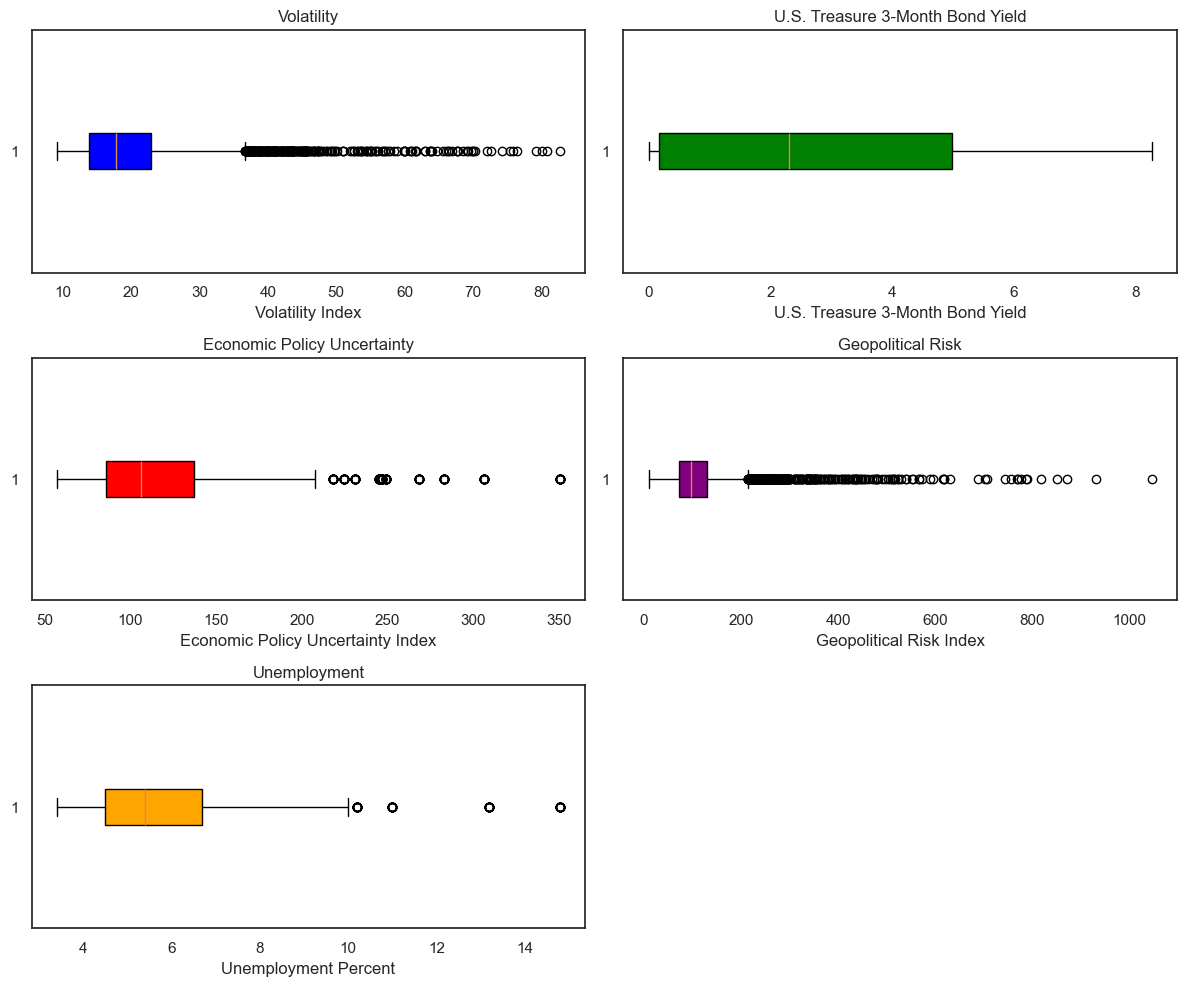

In [187]:
# Creating a Figure to Hold all Boxplot Subplots
fig1 = plt.figure(figsize = (12, 10))

# Creating the Subplots
ax1 = fig1.add_subplot(3, 2, 1)

ax2 = fig1.add_subplot(3, 2, 2)

ax3 = fig1.add_subplot(3, 2, 3)

ax4 = fig1.add_subplot(3, 2, 4)

ax5 = fig1.add_subplot(3, 2, 5)

# Creating the Boxplot for Volatility
ax1.boxplot(x = stock_data_final['vix'], vert = False, patch_artist = True, boxprops = dict(facecolor = 'blue'))

# Setting the Title and X-Axis Label
ax1.set_title('Volatility')
ax1.set_xlabel('Volatility Index')

# Creating the Boxplot for the U.S. Treasury 3-Month Bond Yield
ax2.boxplot(x = stock_data_final['us3m'], vert = False, patch_artist = True, boxprops = dict(facecolor = 'green'))

# Setting the Title and X-Axis Label
ax2.set_title('U.S. Treasure 3-Month Bond Yield')
ax2.set_xlabel('U.S. Treasure 3-Month Bond Yield')

# Creating the Boxplot for Economic Policy Uncertainty Index
ax3.boxplot(x = stock_data_final['epu'], vert = False, patch_artist = True, boxprops = dict(facecolor = 'red'))

# Setting the Title and X-Axis Label
ax3.set_title('Economic Policy Uncertainty')
ax3.set_xlabel('Economic Policy Uncertainty Index')

# Creating the Boxplot for Geopolitical Risk Index
ax4.boxplot(x = stock_data_final['GPRD'], vert = False, patch_artist = True, boxprops = dict(facecolor = 'purple'))

# Setting the Title and X-Axis Label
ax4.set_title('Geopolitical Risk')
ax4.set_xlabel('Geopolitical Risk Index')

# Creating the Boxplot for Unemployment Percent
ax5.boxplot(x = stock_data_final['Unemployment Percent'], vert = False, patch_artist = True, boxprops = dict(facecolor = 'orange'))

# Setting the Title and X-Axis Label
ax5.set_title('Unemployment')
ax5.set_xlabel('Unemployment Percent')

# Adding Padding to the Graphs
fig1.tight_layout(pad=1.0)

# Displaying the Plot
plt.show()

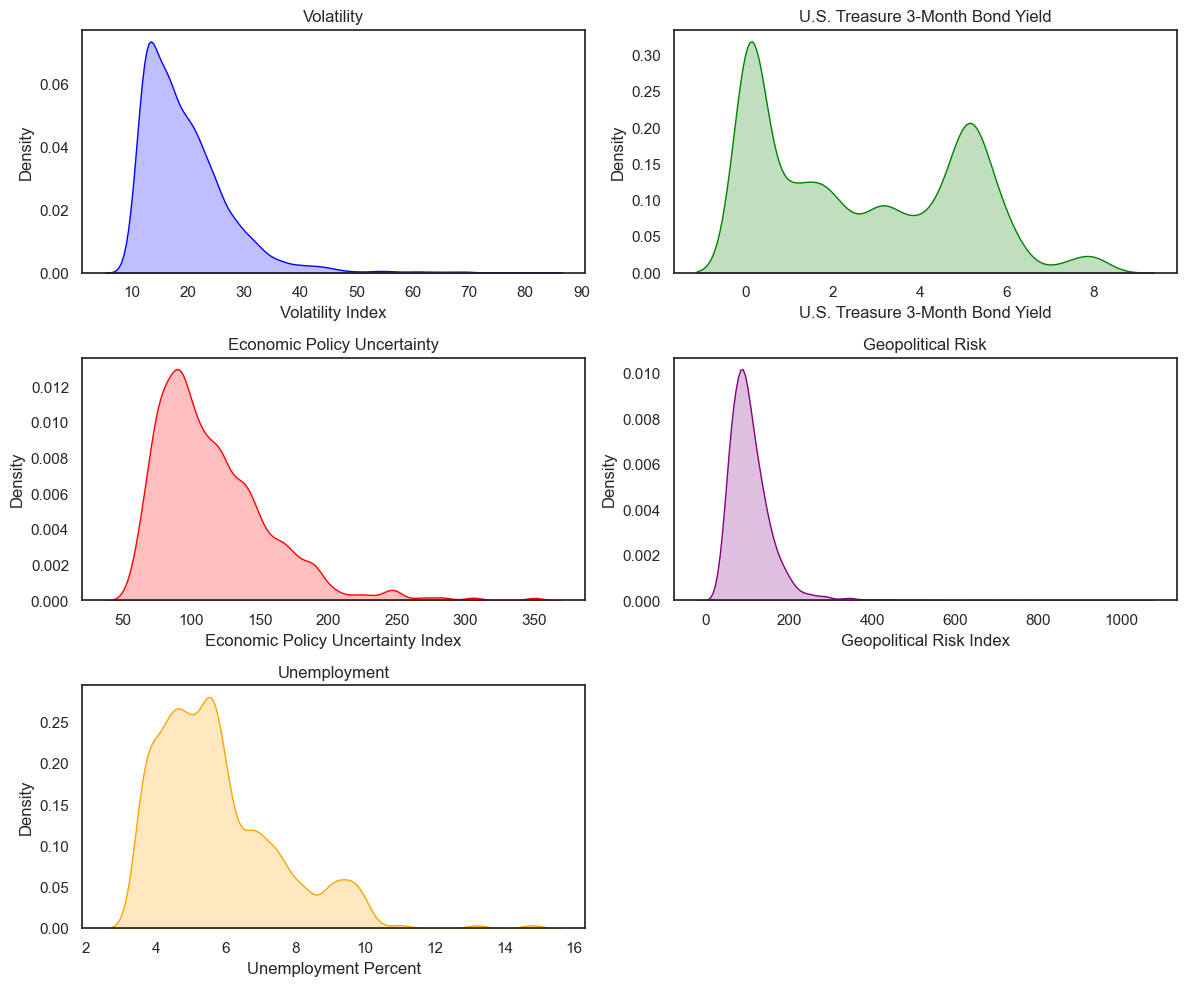

In [188]:
# Setting the Density Plot Theme
sns.set_theme(style = 'white')

# Creating a Figure to Hold all Denisty Plot Subplots
fig2 = plt.figure(figsize = (12, 10))

# Creating the Subplots
ax1 = fig2.add_subplot(3, 2, 1)

ax2 = fig2.add_subplot(3, 2, 2)

ax3 = fig2.add_subplot(3, 2, 3)

ax4 = fig2.add_subplot(3, 2, 4)

ax5 = fig2.add_subplot(3, 2, 5)

# Creating the Density Plot for Volatility
sns.kdeplot(stock_data_final['vix'], fill = True, ax = ax1, color = 'blue')

# Setting the Title and X-Axis Label
ax1.set_title('Volatility')
ax1.set_xlabel('Volatility Index')

# Creating the Density Plot for the U.S. Treasury 3-Month Bond Yield
sns.kdeplot(stock_data_final['us3m'], fill = True, ax = ax2, color = 'green')

# Setting the Title and X-Axis Label
ax2.set_title('U.S. Treasure 3-Month Bond Yield')
ax2.set_xlabel('U.S. Treasure 3-Month Bond Yield')

# Creating the Density Plot for Economic Policy Uncertainty Index
sns.kdeplot(stock_data_final['epu'], fill = True, ax = ax3, color = 'red')

# Setting the Title and X-Axis Label
ax3.set_title('Economic Policy Uncertainty')
ax3.set_xlabel('Economic Policy Uncertainty Index')

# Creating the Density Plot for Geopolitical Risk Index
sns.kdeplot(stock_data_final['GPRD'], fill = True, ax = ax4, color = 'purple')

# Setting the Title and X-Axis Label
ax4.set_title('Geopolitical Risk')
ax4.set_xlabel('Geopolitical Risk Index')

# Creating the Density Plot for Unemployment Percent
sns.kdeplot(stock_data_final['Unemployment Percent'], fill = True, ax = ax5, color = 'orange')

# Setting the Title and X-Axis Label
ax5.set_title('Unemployment')
ax5.set_xlabel('Unemployment Percent')

# Adding Padding to the Graphs
fig2.tight_layout(pad=1.0)

# Displaying the Plot
plt.show()

<Figure size 800x600 with 0 Axes>

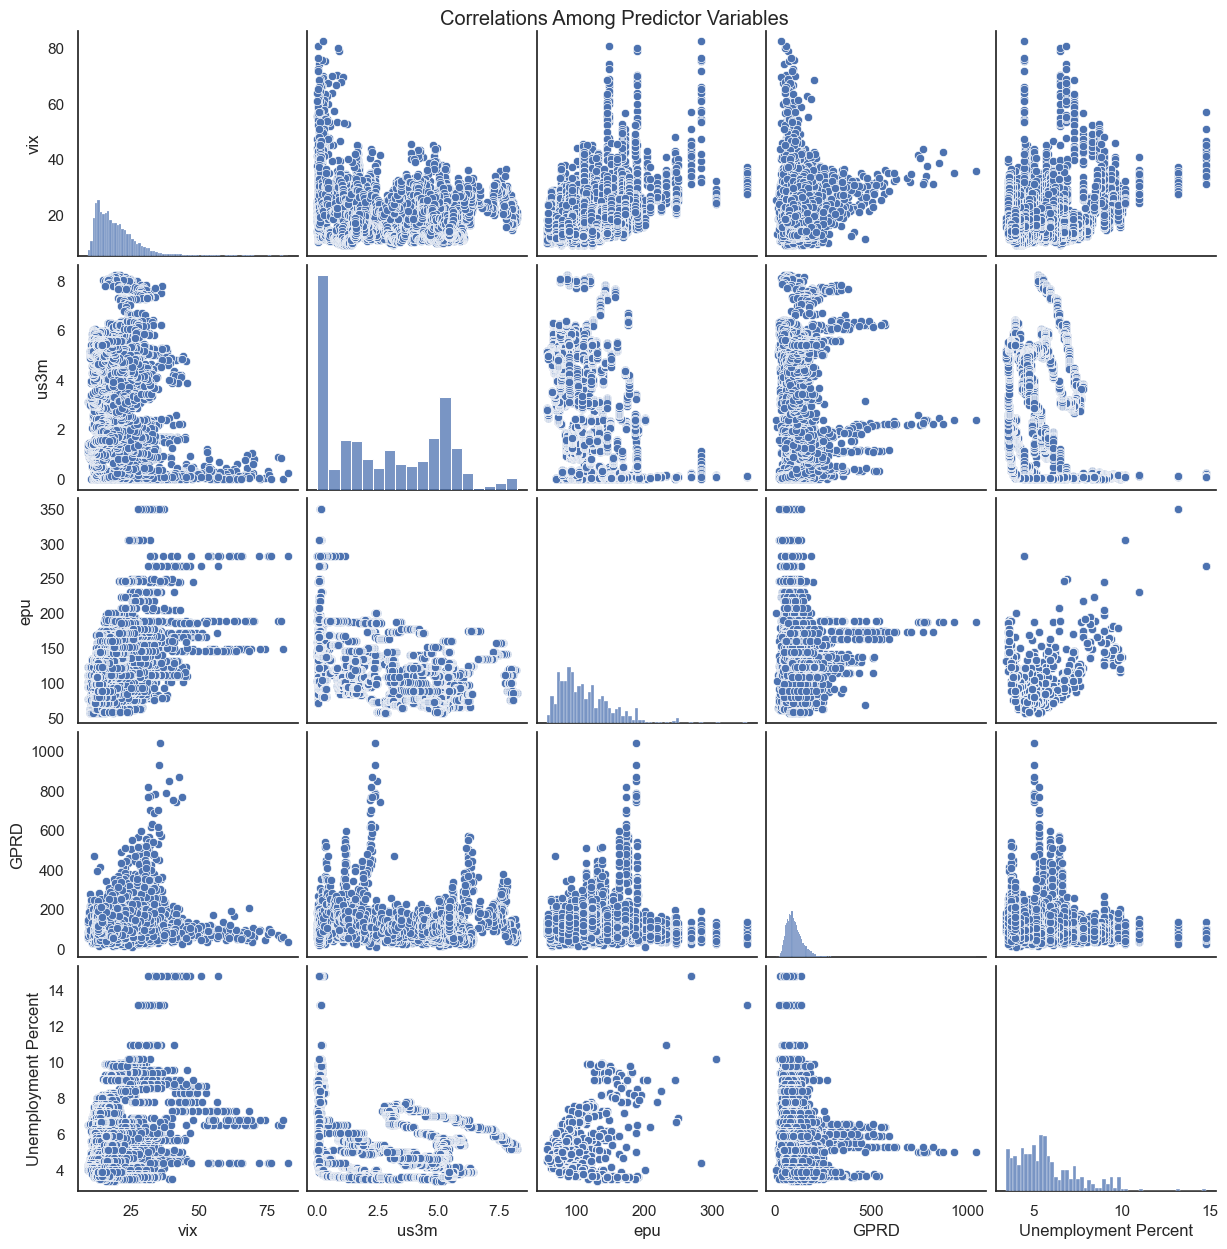

In [189]:
# Selecting a Subset of Relevant Features for the purpose of Creating the Pairplot
stock_data_sample = stock_data_final[['vix', 'us3m', 'epu', 'GPRD', 'Unemployment Percent']]

# Creating the plot
plt.figure(figsize = (8, 6))

# Creating the pairplot
stock_data_pairplot = sns.pairplot(stock_data_sample)

# Creating a Plot Title
stock_data_pairplot.fig.suptitle('Correlations Among Predictor Variables', y = 1)

plt.show()

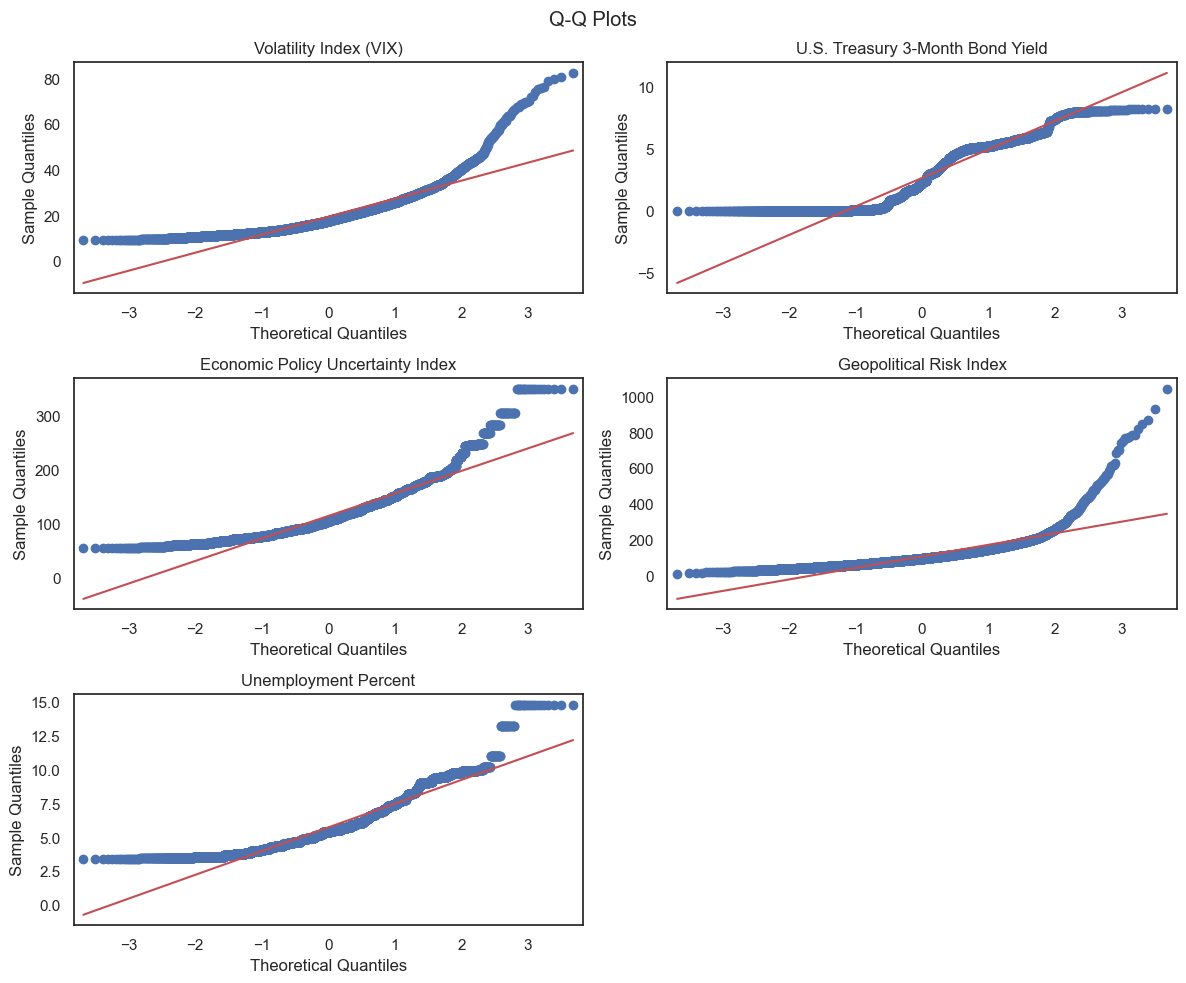

In [190]:
# Extracting the Desired Columns
stock_data_sample = stock_data_final[['vix', 'us3m', 'epu', 'GPRD', 'Unemployment Percent']]

# Creating the Columns Variable for the for loop
columns_to_plot = stock_data_sample.columns

# Creating a Dictionary to Map the Variable Names to
column_name_mapping = {
    'vix': 'Volatility Index (VIX)',
    'us3m': 'U.S. Treasury 3-Month Bond Yield',
    'epu': 'Economic Policy Uncertainty Index',
    'GPRD': 'Geopolitical Risk Index',
    'Unemployment Percent': 'Unemployment Percent'
}

# Creating the Figure for the Q-Q Subplots
fig3, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 10))

# Flatten the Axes Array to Iterate over all Subplots
axes_flat = axes.flatten()

# Iterate through columns and corresponding axes and Creating the Q-Q Plots
for k, ax in zip(columns_to_plot, axes_flat):
    # Mapping the Variables to their New Names
    new_name = column_name_mapping.get(k, k)

    # Creating the Q-Q Plots
    sm.qqplot(stock_data_sample[k], line='s', ax=ax)
    ax.set_title(new_name)

# Hiding any Unused Subplots
for ax in axes_flat[len(columns_to_plot):]:
    ax.axis('off')

# Setting the Plot Title
fig3.suptitle('Q-Q Plots')

# Adding Padding to the Graphs
fig3.tight_layout(pad=1.0)

# Displaying the Plots
plt.show()

In [191]:
# standardizing all variables in a copy, so we can reasign no scaled values as we need them
stock_scaler = StandardScaler()
scaled_stock_data = stock_scaler.fit_transform(stock_data_final.select_dtypes(include='number'))
scaled_stock_data_df = pd.DataFrame(
    scaled_stock_data, 
    columns=stock_data_final.select_dtypes(include='number').columns)
scaled_stock_data_df


,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
0,-0.173406,-1.119073,-1.229674,-1.202881,-1.193641,-1.891889,-0.043521,2.264534,0.454271,-0.365717,-0.527033,-1.118280,-1.679591,-1.606180,-0.204872
1,-0.043064,-1.121866,-1.237973,-1.204394,-1.188029,-1.890624,-0.053299,2.242758,0.454271,-0.365717,-0.826304,-1.119121,-1.679591,-1.606180,-0.204872
2,0.069561,-1.125003,-1.247972,-1.206925,-1.218554,-1.894447,-0.061975,2.220983,0.454271,-0.365717,-0.706085,-1.121916,-1.679591,-1.606180,-0.204872
3,0.088543,-1.123566,-1.257943,-1.204584,-1.246086,-1.897699,-0.080964,2.220983,0.454271,-0.365717,-0.102138,-1.125054,-1.679591,-1.606180,-0.204872
4,0.334040,-1.127335,-1.249769,-1.207728,-1.252146,-1.896883,-0.084340,2.225338,0.454271,-0.365717,0.449164,-1.123616,-1.679591,-1.606180,-0.204872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,-0.712488,3.096419,0.726484,2.785903,0.579768,-0.138357,0.039769,1.193180,-1.335541,-0.633662,0.732415,3.102709,1.770573,-1.315276,-1.062892
8593,-0.469521,3.034341,0.995243,2.727669,0.917481,-0.138357,0.052629,1.201891,-1.335541,-0.633662,1.214641,3.098395,1.770573,-1.315276,-1.062892
8594,-0.655542,3.077236,0.748063,2.744426,0.618971,-0.120289,0.063919,1.193180,-1.335541,-0.633662,0.408486,3.036286,1.770573,-1.315276,-1.062892
8595,-0.702364,3.103552,0.906340,2.783157,0.876707,-0.111411,0.073641,1.193180,-1.335541,-0.633662,1.632051,3.079202,1.770573,-1.315276,-1.062892


In [192]:
# standardizing all variables in a copy, so we can reasign no scaled values as we need them
unemployment_scaler = StandardScaler()
scaled_unemployment_data = unemployment_scaler.fit_transform(
    unemployment.select_dtypes(include='number')
    )
scaled_unemployment_data_df = pd.DataFrame(
    scaled_unemployment_data, 
    columns=unemployment.select_dtypes(include='number').columns)
scaled_unemployment_data_df

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,-1.683251,-0.151699,-0.205196,-0.272221,-0.240903,-0.229759,-0.339189,-0.160600,-0.010384,0.139052,0.164844,0.353397,0.421251
1,-1.584236,0.480381,0.613788,0.730700,0.345252,0.501293,0.586579,0.577513,0.716499,0.747402,0.847265,0.845691,1.038147
2,-1.485221,1.049253,1.117778,1.106795,0.660874,0.842450,1.076691,1.088514,1.140514,1.173248,1.033379,1.091839,1.099837
3,-1.386207,1.049253,0.928782,0.856065,0.525607,0.598766,0.641036,0.634291,0.655925,0.625732,0.723188,0.599544,0.544631
4,-1.287192,0.606797,0.613788,0.542652,0.209985,0.111398,0.150923,0.180067,0.171337,0.139052,0.102806,-0.015824,-0.072265
5,-1.188177,-0.025283,-0.142197,-0.146856,-0.060548,-0.132286,-0.121361,-0.047045,-0.010384,-0.043454,-0.083308,-0.015824,-0.010575
6,-1.089162,-0.025283,-0.079198,-0.084174,-0.150726,-0.132286,-0.284732,-0.160600,-0.373826,-0.286794,-0.269423,-0.138897,-0.133954
7,-0.990148,-0.214907,-0.268195,-0.272221,-0.376170,-0.473443,-0.448103,-0.501268,-0.555546,-0.469299,-0.579614,-0.631192,-0.565781
8,-0.891133,-0.657363,-0.646187,-0.585634,-0.736881,-0.717127,-0.720387,-0.728380,-0.737267,-0.651804,-0.703691,-0.754265,-0.750850
9,-0.792118,-0.846987,-0.772185,-0.899047,-0.736881,-0.814600,-0.829301,-0.841936,-0.918988,-0.895145,-0.951843,-0.938876,-0.997608
